# Notebook 2: Inverted Pendulum Physics

Before we can control the inverted pendulum, we need to understand the physics behind it. In this notebook, we'll explore the equations of motion and develop intuition for how the system behaves.

## What You'll Learn

1. The physical setup of the cart-pole system
2. State variables and what they represent
3. The equations of motion
4. Why balancing is difficult (unstable equilibrium)
5. Energy considerations

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle
from src.environments import InvertedPendulumEnv

## 1. The Physical Setup

The inverted pendulum consists of:

- **Cart**: A wheeled platform that can move horizontally on a track
- **Pole**: A rigid rod attached to the cart by a frictionless pivot
- **Track**: A bounded region where the cart can move

### Physical Parameters

| Parameter | Symbol | Default Value | Unit |
|-----------|--------|---------------|------|
| Gravity | g | 9.81 | m/s² |
| Cart mass | M | 1.0 | kg |
| Pole mass | m | 0.1 | kg |
| Pole half-length | L | 0.5 | m |
| Max force | F | 10.0 | N |

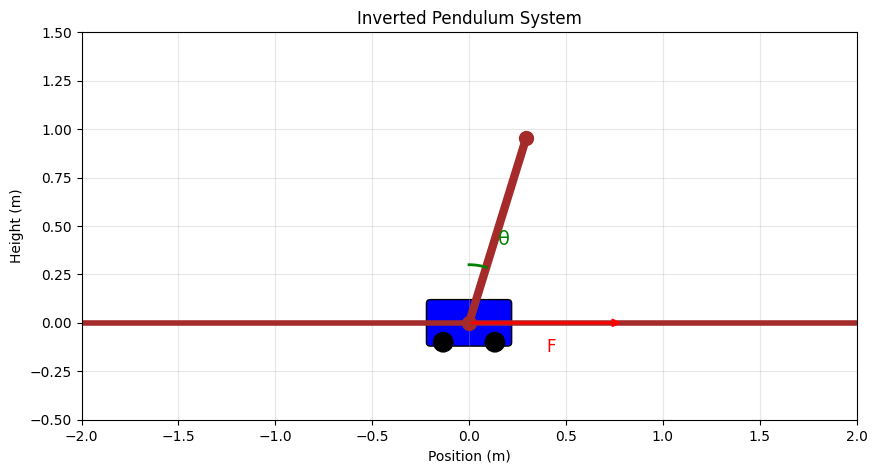

In [2]:
# Let's visualize the setup
def draw_pendulum(ax, x=0, theta=0.3, pole_length=0.5):
    """Draw the cart-pole system."""
    cart_width = 0.4
    cart_height = 0.2
    
    # Track
    ax.axhline(y=0, color='brown', linewidth=4)
    
    # Cart
    cart = FancyBboxPatch(
        (x - cart_width/2, -cart_height/2),
        cart_width, cart_height,
        boxstyle="round,pad=0.02",
        facecolor='blue', edgecolor='black'
    )
    ax.add_patch(cart)
    
    # Wheels
    wheel1 = Circle((x - cart_width/3, -cart_height/2), 0.05, color='black')
    wheel2 = Circle((x + cart_width/3, -cart_height/2), 0.05, color='black')
    ax.add_patch(wheel1)
    ax.add_patch(wheel2)
    
    # Pole
    pole_x = x + 2*pole_length * np.sin(theta)
    pole_y = 2*pole_length * np.cos(theta)
    ax.plot([x, pole_x], [0, pole_y], 'o-', color='brown', linewidth=6, markersize=10)
    
    # Labels
    ax.annotate('', xy=(x + 0.8, 0), xytext=(x, 0),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.text(x + 0.4, -0.15, 'F', fontsize=12, color='red')
    
    # Angle arc
    if abs(theta) > 0.05:
        angle_arc = np.linspace(0, theta, 20)
        arc_r = 0.3
        ax.plot(x + arc_r * np.sin(angle_arc), arc_r * np.cos(angle_arc), 'g-', lw=2)
        ax.text(x + 0.15, 0.4, 'θ', fontsize=14, color='green')

fig, ax = plt.subplots(figsize=(10, 6))
draw_pendulum(ax, x=0, theta=0.3)
ax.set_xlim(-2, 2)
ax.set_ylim(-0.5, 1.5)
ax.set_aspect('equal')
ax.set_xlabel('Position (m)')
ax.set_ylabel('Height (m)')
ax.set_title('Inverted Pendulum System')
ax.grid(True, alpha=0.3)
plt.show()

## 2. State Variables

The system's state is completely described by 4 variables:

### Position Variables
- **x**: Cart position along the track (m)
  - x = 0 is the center
  - Positive x is to the right
  
- **θ (theta)**: Pole angle from vertical (rad)
  - θ = 0 means perfectly upright
  - Positive θ means leaning right

### Velocity Variables
- **ẋ (x_dot)**: Cart velocity (m/s)
  - Positive means moving right
  
- **θ̇ (theta_dot)**: Angular velocity (rad/s)
  - Positive means rotating clockwise (falling right)

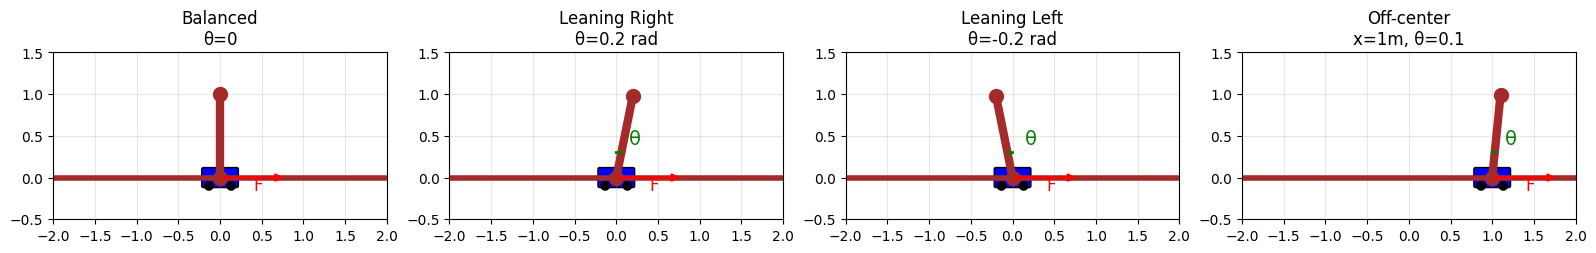

In [3]:
# Let's explore different states
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

states = [
    (0, 0, "Balanced\nθ=0"),
    (0, 0.2, "Leaning Right\nθ=0.2 rad"),
    (0, -0.2, "Leaning Left\nθ=-0.2 rad"),
    (1, 0.1, "Off-center\nx=1m, θ=0.1")
]

for ax, (x, theta, title) in zip(axes, states):
    draw_pendulum(ax, x=x, theta=theta)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Equations of Motion

The equations of motion are derived from Newton's laws (or Lagrangian mechanics). They describe how the system evolves over time given a force F.

### Angular Acceleration

$$\ddot{\theta} = \frac{g \sin(\theta) - \cos(\theta) \left[ \frac{F + mL\dot{\theta}^2 \sin(\theta)}{M+m} \right]}{L \left( \frac{4}{3} - \frac{m \cos^2(\theta)}{M+m} \right)}$$

### Cart Acceleration

$$\ddot{x} = \frac{F + mL(\dot{\theta}^2 \sin(\theta) - \ddot{\theta} \cos(\theta))}{M+m}$$

Don't worry if these look complicated! The key insights are:

1. **Gravity pulls the pole down** (the $g \sin(\theta)$ term)
2. **The cart can counteract this** (the force F affects θ̈)
3. **The pole affects the cart** (moving pole creates forces on cart)

In [4]:
# Let's see how the system evolves without any control
env = InvertedPendulumEnv()

# Start with a small angle
initial_state = [0, 0, 0.05, 0]  # Small lean to the right
state = env.reset(initial_state=initial_state)

print("No force applied (F=0). Watching the pole fall...\n")

done = False
step = 0
while not done and step < 50:
    state, reward, done, info = env.step(0)  # No force
    if step % 5 == 0:
        print(f"Step {step:3d}: θ = {np.degrees(state[2]):6.2f}°")
    step += 1

print(f"\nPole fell at step {step}!")
print(f"Final angle: {np.degrees(state[2]):.1f}°")

No force applied (F=0). Watching the pole fall...

Step   0: θ =   2.86°
Step   5: θ =   8.19°

Pole fell at step 8!
Final angle: 12.9°


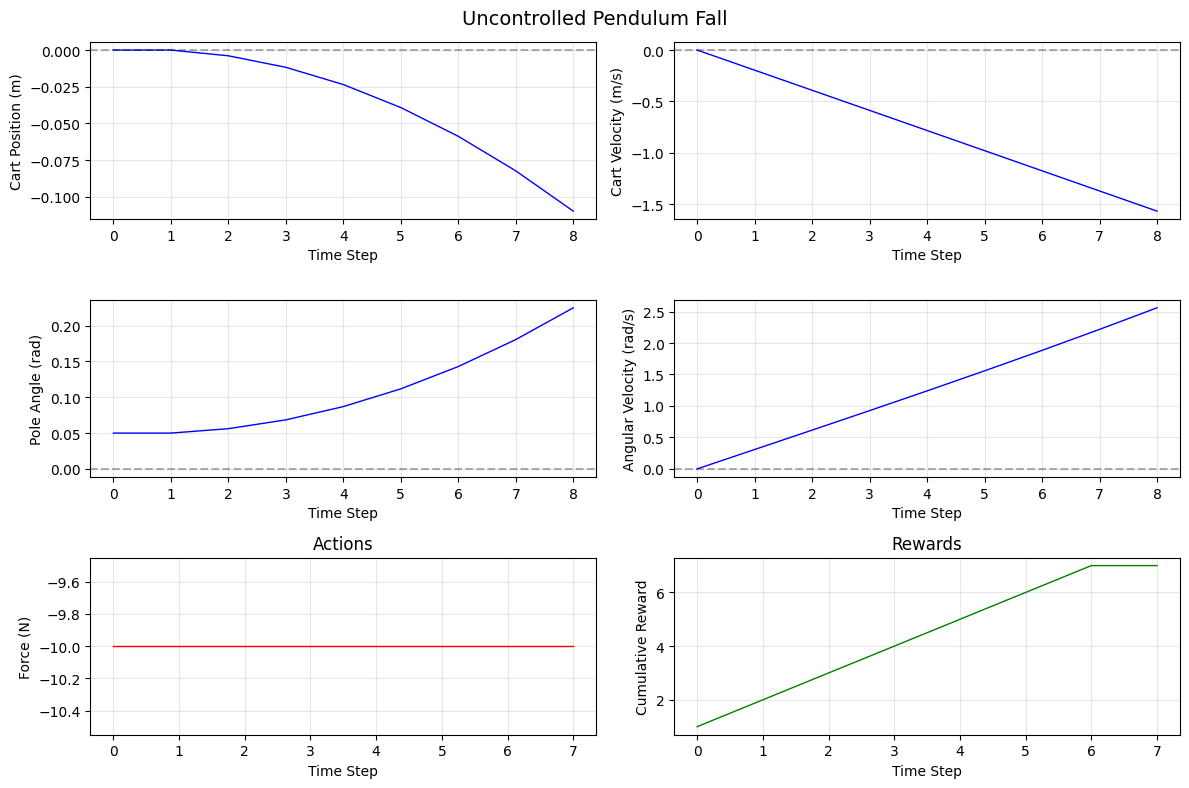

In [5]:
# Visualize the fall
from src.utils import plot_trajectory

history = env.get_history()
fig = plot_trajectory(history, title="Uncontrolled Pendulum Fall")
plt.show()

## 4. Why Balancing is Difficult

The inverted pendulum is an **unstable equilibrium**:

### Stable vs Unstable Equilibrium

- **Stable** (like a ball in a bowl): If disturbed, returns to equilibrium
- **Unstable** (like a ball on a hill): If disturbed, moves away from equilibrium

The upright position (θ=0) is unstable because:
- Any small angle → gravity creates torque → angle increases → more torque → falls!

### The Control Challenge

To balance, we must:
1. Detect which way the pole is leaning
2. Move the cart to "catch" it
3. Do this continuously and quickly!

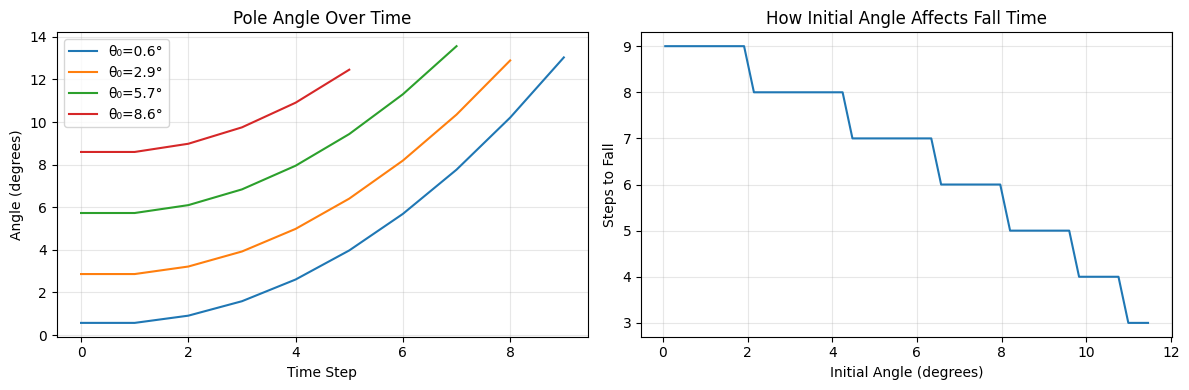

In [6]:
# Compare falls from different initial angles
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

initial_angles = [0.01, 0.05, 0.1, 0.15]  # radians

for theta0 in initial_angles:
    env = InvertedPendulumEnv()
    state = env.reset(initial_state=[0, 0, theta0, 0])
    
    angles = [theta0]
    done = False
    while not done:
        state, _, done, _ = env.step(0)
        angles.append(state[2])
    
    axes[0].plot(np.degrees(angles), label=f'θ₀={np.degrees(theta0):.1f}°')

axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Angle (degrees)')
axes[0].set_title('Pole Angle Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show time to fall vs initial angle
times_to_fall = []
test_angles = np.linspace(0.001, 0.2, 50)

for theta0 in test_angles:
    env = InvertedPendulumEnv()
    state = env.reset(initial_state=[0, 0, theta0, 0])
    
    step = 0
    done = False
    while not done:
        state, _, done, _ = env.step(0)
        step += 1
    times_to_fall.append(step)

axes[1].plot(np.degrees(test_angles), times_to_fall)
axes[1].set_xlabel('Initial Angle (degrees)')
axes[1].set_ylabel('Steps to Fall')
axes[1].set_title('How Initial Angle Affects Fall Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Energy Considerations

Another way to understand the system is through energy:

### Kinetic Energy
Energy of motion:
- Cart: $KE_{cart} = \frac{1}{2}M\dot{x}^2$
- Pole: Translation + rotation

### Potential Energy
Energy of position:
- $PE = mgh = mgL\cos(\theta)$

The goal is to keep the pole at maximum potential energy (upright)!

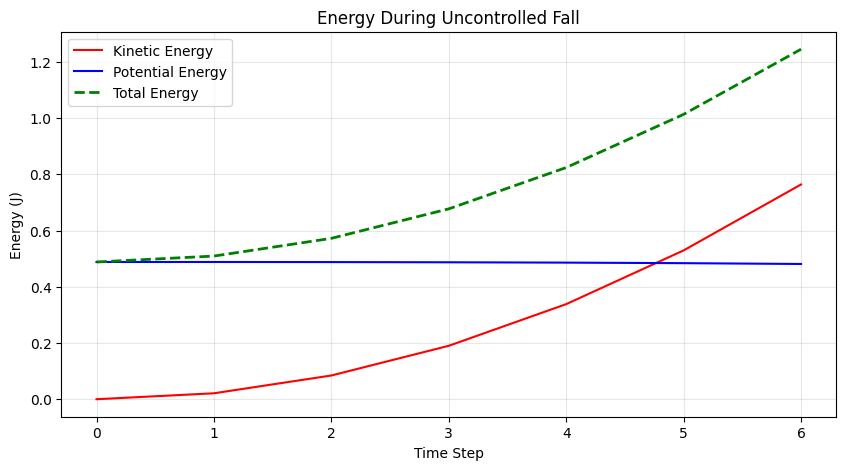

Notice: Total energy is conserved (no friction)!
Potential energy converts to kinetic as the pole falls.


In [7]:
# Let's track energy during a fall
env = InvertedPendulumEnv()
state = env.reset(initial_state=[0, 0, 0.1, 0])

kinetic = []
potential = []
total = []

done = False
while not done:
    energy = env.get_energy()
    kinetic.append(energy['kinetic'])
    potential.append(energy['potential'])
    total.append(energy['total'])
    
    state, _, done, _ = env.step(0)  # No force

# Plot energy
fig, ax = plt.subplots(figsize=(10, 5))
steps = range(len(kinetic))

ax.plot(steps, kinetic, 'r-', label='Kinetic Energy')
ax.plot(steps, potential, 'b-', label='Potential Energy')
ax.plot(steps, total, 'g--', label='Total Energy', linewidth=2)

ax.set_xlabel('Time Step')
ax.set_ylabel('Energy (J)')
ax.set_title('Energy During Uncontrolled Fall')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("Notice: Total energy is conserved (no friction)!")
print("Potential energy converts to kinetic as the pole falls.")

## Interactive Exploration

Let's build intuition by manually controlling the pendulum!

In [8]:
# Simple manual control experiment
env = InvertedPendulumEnv()
state = env.reset(initial_state=[0, 0, 0.1, 0])  # Leaning right

print("Experiment: What happens with different control strategies?\n")

# Strategy 1: No control
env.reset(initial_state=[0, 0, 0.1, 0])
for _ in range(100):
    state, _, done, _ = env.step(0)
    if done:
        break
steps_no_control = env.steps
print(f"Strategy 1 (No control):        {steps_no_control} steps")

# Strategy 2: Push in direction of lean (correct!)
env.reset(initial_state=[0, 0, 0.1, 0])
for _ in range(100):
    theta = env.state[2]
    force = 10.0 if theta > 0 else -10.0  # Push toward the lean
    state, _, done, _ = env.step(force)
    if done:
        break
steps_correct = env.steps
print(f"Strategy 2 (Push toward lean): {steps_correct} steps")

# Strategy 3: Push away from lean (wrong!)
env.reset(initial_state=[0, 0, 0.1, 0])
for _ in range(100):
    theta = env.state[2]
    force = -10.0 if theta > 0 else 10.0  # Push away from lean
    state, _, done, _ = env.step(force)
    if done:
        break
steps_wrong = env.steps
print(f"Strategy 3 (Push away):        {steps_wrong} steps")

print("\nThe correct strategy is to push in the direction of the lean!")
print("This moves the cart under the falling pole to catch it.")

Experiment: What happens with different control strategies?

Strategy 1 (No control):        7 steps
Strategy 2 (Push toward lean): 31 steps
Strategy 3 (Push away):        7 steps

The correct strategy is to push in the direction of the lean!
This moves the cart under the falling pole to catch it.


## Exercises

### Exercise 1: Parameter Exploration
Change the physical parameters and observe their effects:
- What happens with a heavier pole?
- What about a longer pole?
- Try different gravity values

### Exercise 2: Initial Conditions
Try different initial states and see how long the pole balances with no control.

### Exercise 3: Better Control
Can you improve the simple control strategy? Try using both angle and angular velocity.

In [9]:
# Exercise 3: Try a better control strategy
# Hint: Use both theta and theta_dot

env = InvertedPendulumEnv()
state = env.reset(initial_state=[0, 0, 0.15, 0.5])  # Harder initial condition

done = False
while not done:
    theta = state[2]
    theta_dot = state[3]
    
    # Your control law here:
    # Try different combinations of theta and theta_dot
    force = 10 * theta + 5 * theta_dot  # Simple PD control
    
    state, _, done, _ = env.step(force)

print(f"Balanced for {env.steps} steps!")

Balanced for 11 steps!


## Summary

In this notebook, we learned:

- The **physical setup**: cart, pole, track
- **State variables**: x, ẋ, θ, θ̇
- The **equations of motion** (complex but physics-based)
- **Unstable equilibrium**: small disturbances grow exponentially
- **Energy**: potential converts to kinetic as pole falls
- **Control intuition**: push toward the lean to catch the pole

## Next Steps

In the next notebook, we'll explore the **simulation environment** in detail and learn how to use it for RL experiments!